## Build a regression model.

### Feature Engineering

In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import statsmodels.api as sm
from scipy.stats import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
connection = sqlite3.connect('City_Bikes_information_DB.db')
cur = connection.cursor()
aggregated_dataframe = pd.read_sql_query('SELECT * FROM aggregated_dataframe', connection)

connection.close()

In [3]:
aggregated_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      460 non-null    float64
 1   longitude     460 non-null    float64
 2   total_bikes   460 non-null    float64
 3   review_count  460 non-null    float64
 4   rating        460 non-null    float64
 5   popularity    460 non-null    float64
dtypes: float64(6)
memory usage: 21.7 KB


In [4]:
aggregated_dataframe.describe()

,latitude,longitude,total_bikes,review_count,rating,popularity
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,40.729415,-73.971538,3.369248,2.447753,4.209837,0.978997
std,0.041136,0.033529,0.429592,0.037404,0.108589,0.009384
min,40.664241,-74.071061,2.302585,2.331841,3.875000,0.957015
25%,40.693573,-73.993394,3.044522,2.421770,4.150000,0.971440
50%,40.720788,-73.964631,3.295837,2.443275,4.225000,0.978480
75%,40.763133,-73.946727,3.663562,2.472794,4.275000,0.987859
max,40.814394,-73.907744,4.418841,2.533772,4.450000,0.999584


## Testing for correlation between variables

In [5]:
stats, p_value = scipy.stats.pearsonr(aggregated_dataframe['total_bikes'], aggregated_dataframe['review_count'])
p_value

1.3698059740758493e-27

In [6]:
stats, p_value = scipy.stats.pearsonr(aggregated_dataframe['total_bikes'], aggregated_dataframe['popularity'])
p_value

8.94049852233941e-30

In [7]:
stats, p_value = scipy.stats.pearsonr(aggregated_dataframe['total_bikes'], aggregated_dataframe['rating'])
p_value

0.09763310593156743

These p_values (< 0.05) informs us that there is statistically significant correlation between the number of bikes in a location, the reviews from nearby POIs and popularity index of nearby POIs. There is no statistical evidence of correlation between the number of bikes and the average rating of bars, restaurants, and parks. 

In [8]:
aggregated_dataframe.corr(numeric_only=True)

,latitude,longitude,total_bikes,review_count,rating,popularity
latitude,1.000000,0.283676,0.166615,0.199601,-0.125858,0.403155
longitude,0.283676,1.000000,-0.065606,-0.104631,0.301921,-0.120118
total_bikes,0.166615,-0.065606,1.000000,0.477630,-0.077327,0.494764
review_count,0.199601,-0.104631,0.477630,1.000000,-0.098657,0.450082
rating,-0.125858,0.301921,-0.077327,-0.098657,1.000000,-0.252968
popularity,0.403155,-0.120118,0.494764,0.450082,-0.252968,1.000000


## Feature selection: Backward elimination

In [9]:
y = aggregated_dataframe['total_bikes']
X = aggregated_dataframe.drop('total_bikes', axis=1)
X = sm.add_constant(X) 

model = sm.OLS(y, X)
results = model.fit()

Provide model output and an interpretation of the results. 

In [10]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     44.76
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.55e-37
Time:                        21:33:25   Log-Likelihood:                -171.38
No. Observations:                 460   AIC:                             354.8
Df Residuals:                     454   BIC:                             379.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.2913     51.969      0.275   

In [11]:
y = aggregated_dataframe['total_bikes']
X = aggregated_dataframe.drop(['total_bikes', 'latitude', 'longitude'], axis=1)
X = sm.add_constant(X) 

model = sm.OLS(y, X)
results = model.fit()

In [12]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_bikes   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     74.28
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           3.91e-39
Time:                        21:33:27   Log-Likelihood:                -172.03
No. Observations:                 460   AIC:                             352.1
Df Residuals:                     456   BIC:                             368.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -22.6223      2.073    -10.915   

#### This model has an R^2 value of 0.382 and an adjusted R^2 value of 0.324. All the p_values are also less than 0.05, except for the rating. This agrees with the earlier hypothesis that there is no statistical evidence of correlation between the average rating of POIs and the number of bikes in that location.

The p_values suggest that the review_count and popularity are statistically significant to the total number of bikes in a particular location. The coefficient of the number of reviews shows that although the rating has a positive slope, it does not really have an influence on the number of bikes (as its value is very close to 0). Popularity index has a really strong positive influence on the number of bikes per location. This agrees with realistic inference as restaurants use this index for forecasting.

This basically means, the higher the popularity index, the more the number of bikes in that location.

I didn't really have much time to properly investigate, tweak and modify the model. So it is possible that this statistical model is not reliable due to the following reasons:

1. I used brute-force in removing the outliers (time constraint).
2. I aggregated the popularity index by calculating the mean grouped by location, latitidue and number of bikes. Same process was done for the rating.
3. I reduced the data from 100000 to 400 which was relevant for the analysis I am currently presenting. The reduction was a byproduct of removing null values and outliers.

## Checking the Linear Regression model assumptions by testing for linearity, independence, homoscedasticity, normality and multicolinearity

In [13]:
residuals = results.resid #same unit as target or depend var
residuals

0     -0.158192
1      0.038939
2      0.099795
3      0.045773
4     -0.116436
         ...   
455   -0.219484
456   -0.370838
457    0.107620
458    0.204598
459   -0.278513
Length: 460, dtype: float64

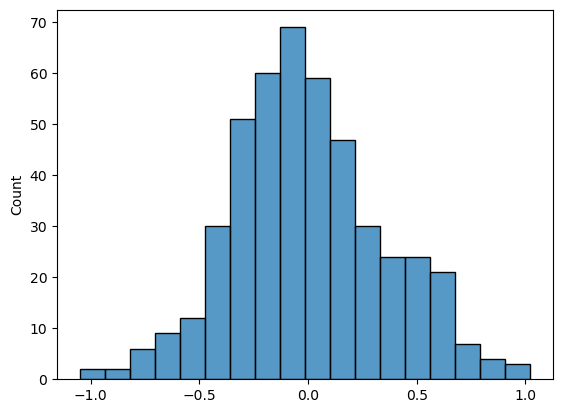

In [14]:
sns.histplot(residuals)
plt.show()

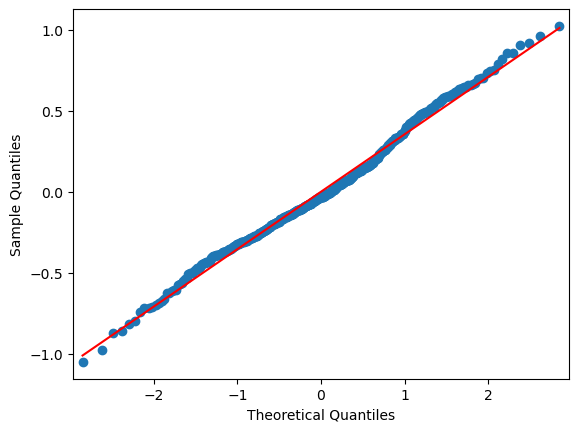

In [15]:
sm.qqplot(residuals, line='r')
plt.show()

### The errors are normally distributed.

In [16]:
scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.9915230870246887, pvalue=0.009910293854773045)

The residuals from the model are normally distributed. We fail to reject the null hypothesis.

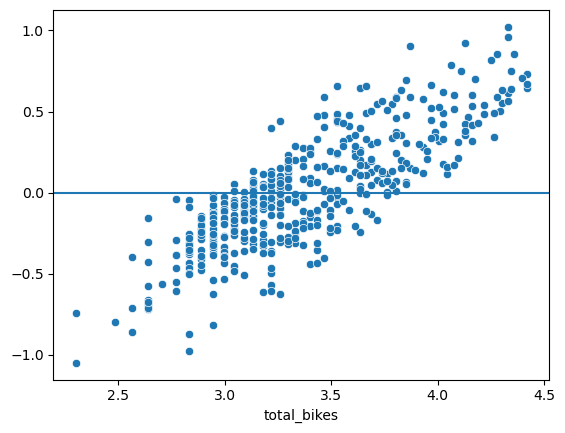

In [17]:
ax = sns.scatterplot(x=aggregated_dataframe['total_bikes'], y=residuals)
ax.axhline(0) #horizontal line at 0

### It seems most likely that the error calcuted from the model does not change across all the values of the independent variables. This means the residuals are not distributed with equal variance.

Hence the model fails the homoscedasticity test. Trying to transform the independent variables by taking their log values (or square root) resulted in -inf values. The results from taking the exponent of the independent variables has no relevance to our analysis from an inferential standpoint.

In [18]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals, results.model.exog)
print(p,f_p)

0.022000784727859473 0.021720011368915104


#### The residuals failed the Breusch-Pagan test. Hence the residuals are don't have equal variance.

In [53]:
results.params

const          -22.622274
review_count     3.661880
rating           0.181687
popularity      16.612179
dtype: float64

# Stretch

How can you turn the regression model into a classification model?